In [93]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [94]:
historical = pd.read_json('historical.json')
fear = pd.read_json('fear.json')

In [95]:
historical['time'] = pd.to_datetime(historical['time'], unit='s')
fear.rename(columns={'timestamp': 'time'}, inplace=True)

In [96]:
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              2001 non-null   datetime64[ns]
 1   high              2001 non-null   float64       
 2   low               2001 non-null   float64       
 3   open              2001 non-null   float64       
 4   volumefrom        2001 non-null   float64       
 5   volumeto          2001 non-null   float64       
 6   close             2001 non-null   float64       
 7   conversionType    2001 non-null   object        
 8   conversionSymbol  2001 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 140.8+ KB


In [97]:
fear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   value                 2000 non-null   int64         
 1   value_classification  2000 non-null   object        
 2   time                  2000 non-null   datetime64[ns]
 3   time_until_update     1 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 62.6+ KB


In [98]:
data = pd.merge(fear, historical, on='time', how='left')
time = data['time']
data.drop(columns=['time_until_update', 'conversionType', 'conversionSymbol', 'value_classification'], inplace=True)
data.rename(columns={"value": "fear_greed"}, inplace=True)

In [99]:
data.head()

,fear_greed,time,high,low,open,volumefrom,volumeto,close
0,48,2025-02-14,98869.28,96282.72,96632.78,17341.29,1.689715e+09,97979.96
1,50,2025-02-13,98104.11,95225.08,97874.61,23246.76,2.236345e+09,96632.78
2,46,2025-02-12,98127.45,94087.33,95781.05,40118.73,3.853980e+09,97874.61
3,47,2025-02-11,98499.44,94852.37,97458.59,29002.62,2.800036e+09,95781.05
4,43,2025-02-10,98363.35,95276.70,96485.60,28119.40,2.731411e+09,97458.59


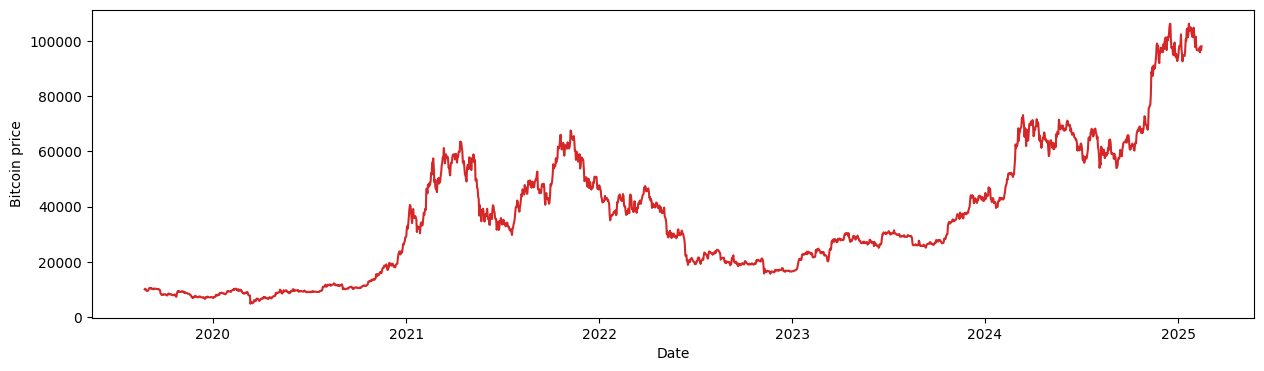

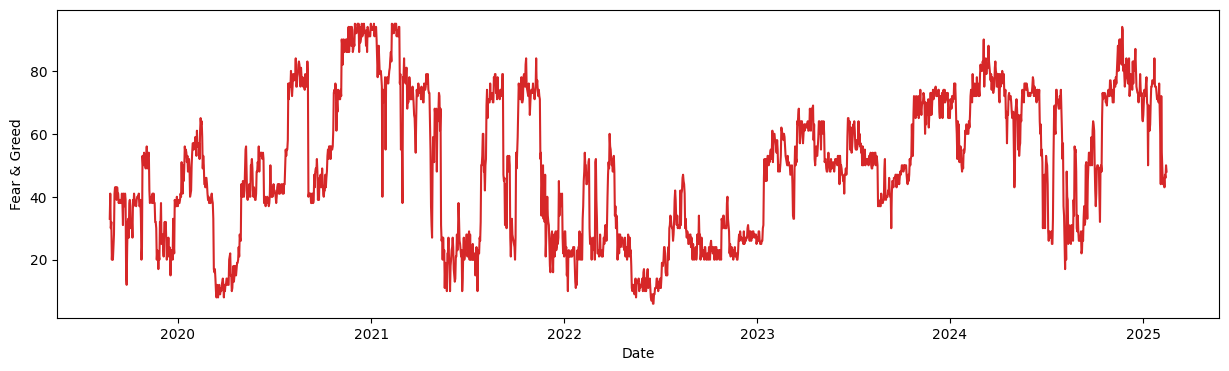

In [102]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, data['time'], data['close'], xlabel='Date', ylabel='Bitcoin price')
plot_df(data, data['time'], data['fear_greed'], xlabel='Date', ylabel='Fear & Greed')